In [1]:
import cv2
import torch
import torch.nn as nn
import numpy as np
import segmentation_models_pytorch as smp
import os
import glob
import matplotlib.pyplot as plt
import random
import time
from torch.utils.data import DataLoader
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import datetime

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
test_folder_imgs = np.array(glob.glob(os.path.join("test128", "images", "*")))
test_folder_labs = np.array(glob.glob(os.path.join("test128", "labels", "*")))

print(len(test_folder_imgs))
test_paths = []
for i in range(len(test_folder_imgs)):
    test_paths.append([test_folder_imgs[i], test_folder_labs[i]])

261


In [3]:
class WoundData(torch.utils.data.Dataset):
    
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Read image and mask
        im = cv2.imread(self.data[idx][0],-1)
        mask = cv2.imread(self.data[idx][1],0)

        # From np.array (HxWxC) to torch.tensor (CxHxW). From [0,255] to [0,1]
        im = torch.from_numpy(np.float32(im/255).transpose(2,0,1))
        mask = torch.from_numpy(np.float32(mask/255)).unsqueeze(0)
        
        return im, mask

In [4]:
test_ds = WoundData(test_paths)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0)

In [68]:
target_model = "trainrun_03122022-213156"
# gan: trainrun_03122022-182817
# nogan: trainrun_03122022-182831
model_path = glob.glob(os.path.join(target_model, "*.pt"))[0]
print(model_path)

ENCODER = 'timm-regnetx_006'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['vein']
DEVICE = 'cuda'

model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    in_channels=3,
)

model.load_state_dict(torch.load(model_path))
model.to(DEVICE);

trainrun_03122022-213156\ganwoundmodel.pt


In [69]:
collated_pred, collated_mask = [], []
collated_img = []
for i, (sampi, sampm) in enumerate(test_dl):
    sampo = torch.sigmoid(model(sampi.to(DEVICE)))
    collated_pred.append(np.array(sampo.cpu().detach()).squeeze())
    collated_mask.append(np.array(sampm.detach()).squeeze())
    collated_img.append(np.array(sampi.cpu().detach().squeeze()).transpose(1,2,0))
    #print(i, len(test_dl))

In [70]:
collated_pred = np.array(collated_pred)
collated_pred.shape

(261, 128, 128)

In [71]:
collated_mask = np.array(collated_mask)
collated_img = np.array(collated_img)
collated_mask.shape, collated_img.shape

((261, 128, 128), (261, 128, 128, 3))

In [72]:
collated_pred_bin = (collated_pred > 0.5).astype(int)

In [73]:
prec = []
rec = []
dice = []
sizes = []
ious = []
ccount = []
median_color = []
var_color = []
inner_colors = []
outer_colors = []

for pred, mask, img in zip(collated_pred_bin, collated_mask, collated_img):
    contours, hierarchy = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)    
    tp = np.sum((pred + mask) == 2)
    tn = np.sum((pred + mask) == 0)
    fp = np.sum((pred - mask) > 0)
    fn = np.sum((pred - mask) < 0)
    coloring = img[np.where(mask==1)]
    try:
        vcolor = np.mean(np.var(coloring,axis=0))
        #print(vcolor)
    except:
        vcolor = 0
    coloring = np.median(coloring,axis=0)
    inner_mask = cv2.erode(mask, (3,3), iterations=3)
    outer_mask =((mask - inner_mask) > 0).astype(np.uint8)
    inner_color = np.median(img[np.where(inner_mask==1)],axis=0)
    outer_color = np.median(img[np.where(outer_mask==1)],axis=0)
    
    prec.append(tp/ (tp + fp + 0.00001))
    rec.append(tp/ (tp + fn + 0.00001))
    dice.append(2*tp/ (2*tp + fn + fp))
    ious.append(tp/(tp+fp+fn))
    sizes.append(np.sqrt(np.sum(mask)))
    ccount.append(len(contours))
    median_color.append(coloring)
    var_color.append(vcolor)
    inner_colors.append(inner_color)
    outer_colors.append(outer_color)

median_color = np.array(median_color)

In [74]:
np.mean(prec), np.mean(rec), np.mean(dice), np.mean(ious)

(0.8637736385693118,
 0.8424961551705852,
 0.8214110436220716,
 0.7282366258271064)

In [48]:
# nogan 0.8411066891895962,
 0.8484627409069824,
 0.8045960825777335,
 0.7072747080806421)

In [49]:
# w/gan 0.8967749233505714,
 0.7854665018963165,
 0.8048895624777689,
 0.7031118311058066

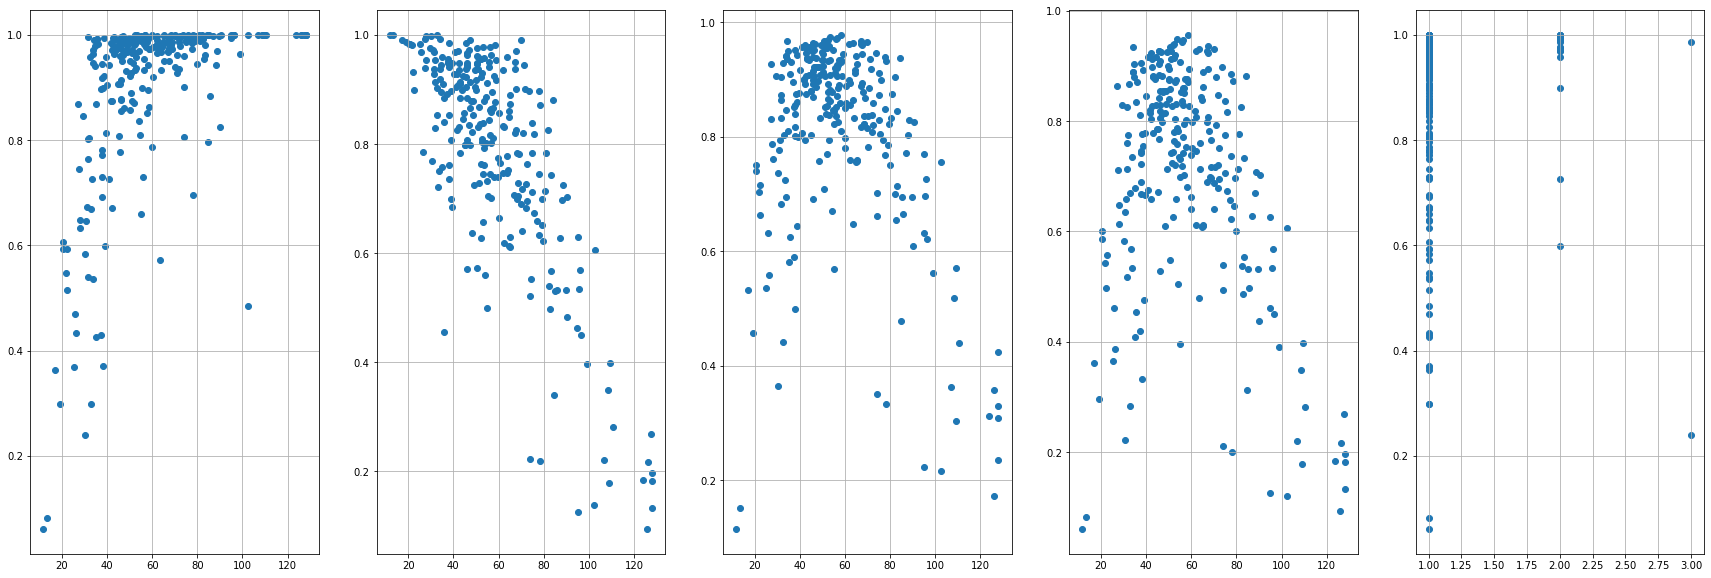

In [50]:
plt.rcParams["figure.figsize"] = (30, 10)
tplots = 5
plt.subplot(1,tplots,1); plt.scatter(sizes, prec); plt.grid()
plt.subplot(1,tplots,2); plt.scatter(sizes, rec); plt.grid()
plt.subplot(1,tplots,3); plt.scatter(sizes, dice); plt.grid()
plt.subplot(1,tplots,4); plt.scatter(sizes, ious); plt.grid()
plt.subplot(1,tplots,5); plt.scatter(ccount, prec); plt.grid()

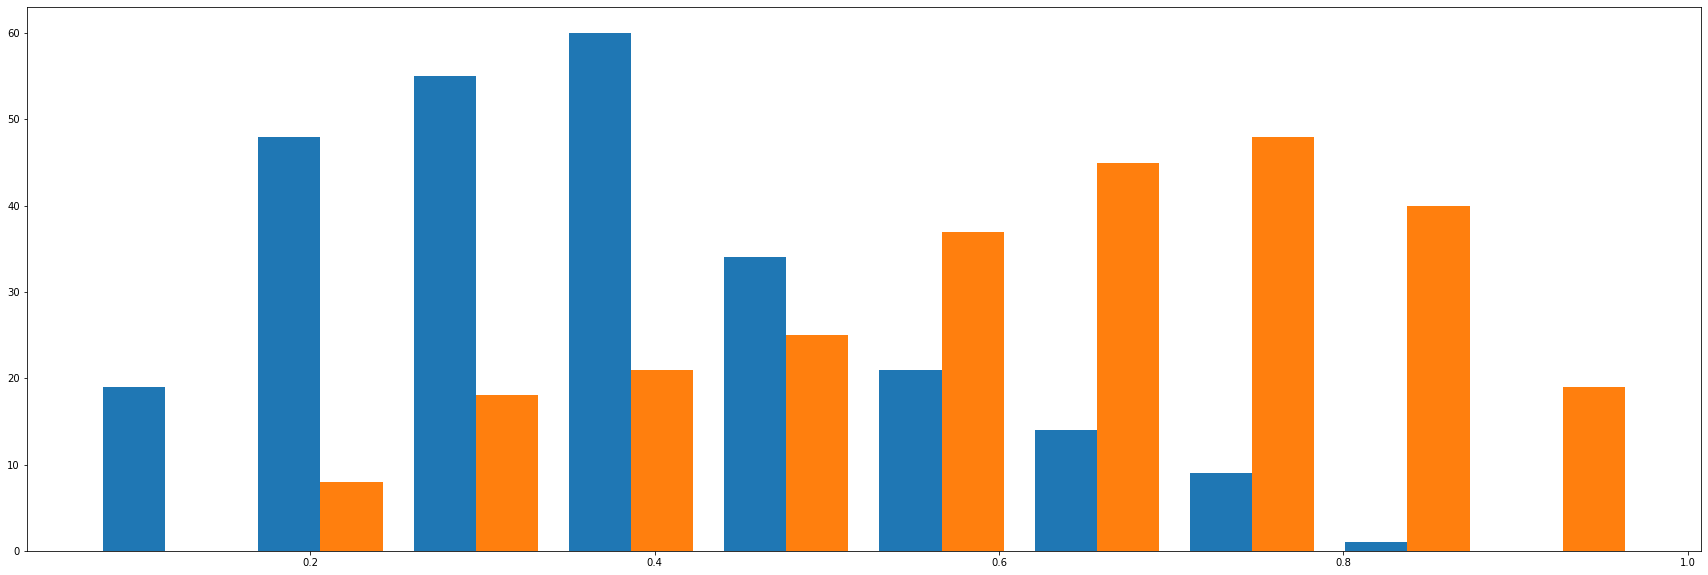

In [22]:
plt.hist(median_color[:,1:]);

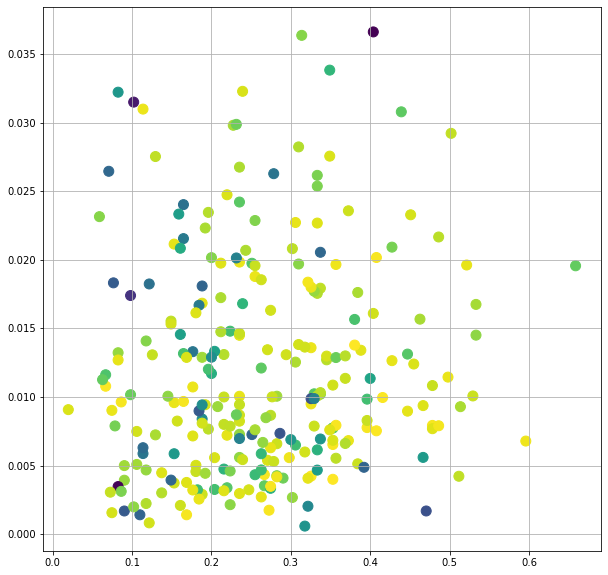

In [24]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.scatter(median_color[:,2]-median_color[:,1], np.array(var_color), c=np.array(dice), s=100)
#plt.ylim([0, 1])
#plt.xlim([0, 1])
plt.grid()

In [ ]:
np.mean(np.array(dice)[median_color[:,1] > 0.6])

In [ ]:
np.mean(np.array(dice)[median_color[:,2] < 0.4])

In [ ]:
np.mean(dice)

In [ ]:
plt.hist(median_color[:,2]-median_color[:,1])

In [34]:
inner_colors = np.array(inner_colors); outer_colors = np.array(outer_colors)
inner_colors.shape, outer_colors.shape

((261, 3), (261, 3))

In [35]:
diff_color = inner_colors - outer_colors

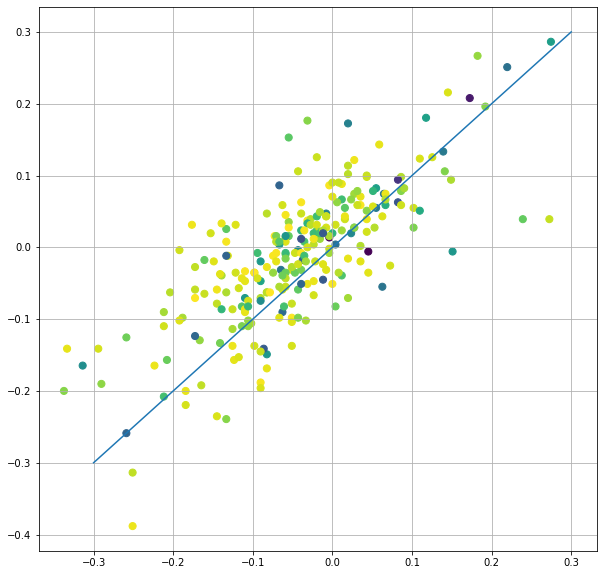

In [38]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.scatter(diff_color[:,1], diff_color[:,2], c=np.array(dice), s=50)
#plt.ylim([0, 1])
#plt.xlim([0, 1])
plt.plot([-0.3, 0.3], [-0.3, 0.3])
plt.grid()

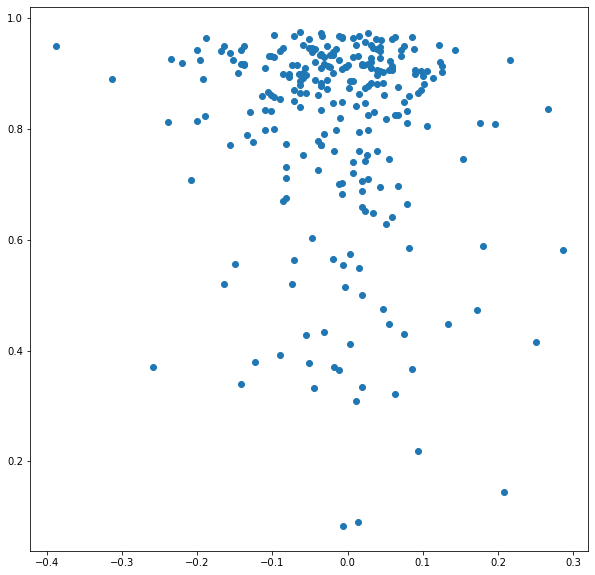

In [39]:
plt.scatter(diff_color[:,2], np.array(dice))

(array([[  1.,   6.,  10.,  20.,  68., 100.,  37.,  10.,   5.,   0.],
        [  2.,   5.,  11.,  33.,  68.,  77.,  39.,  15.,   3.,   4.],
        [  1.,   2.,  10.,  18.,  46.,  79.,  71.,  20.,   7.,   3.]]),
 array([-0.3882353 , -0.32078433, -0.25333333, -0.18588236, -0.11843138,
        -0.0509804 ,  0.01647058,  0.08392155,  0.15137254,  0.2188235 ,
         0.2862745 ], dtype=float32),
 <a list of 3 BarContainer objects>)

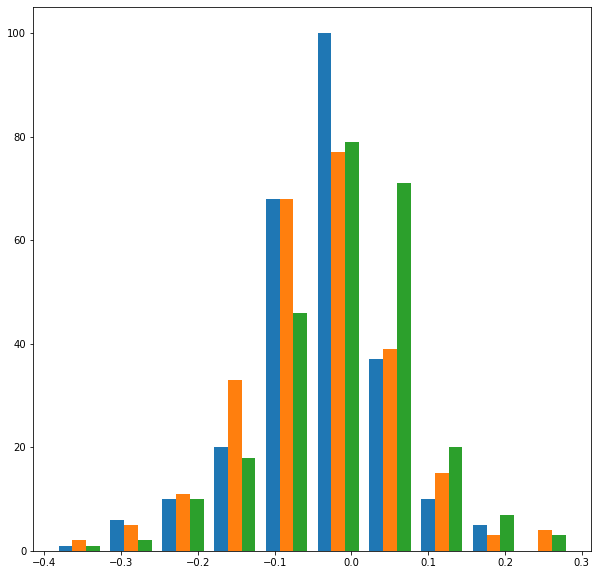

In [40]:
plt.hist(diff_color)